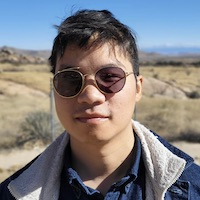

# Laurent Dinh

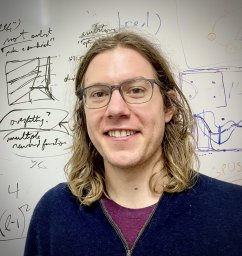

# David Scott Krueger

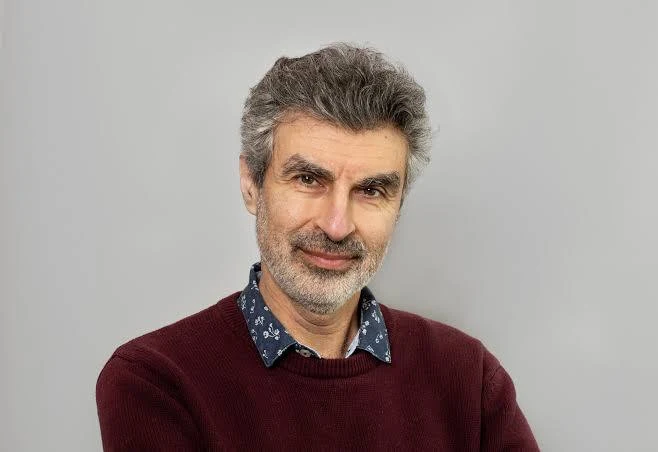

# Yoshua Bengio

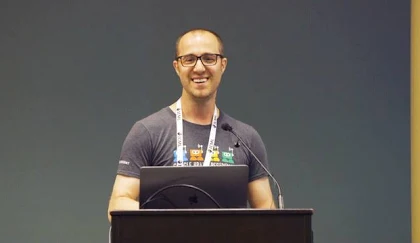

# Jascha Sohl-Dickstein


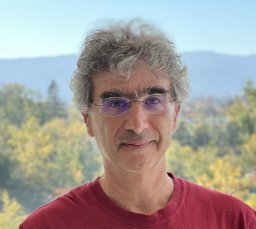

# Samy Bengio

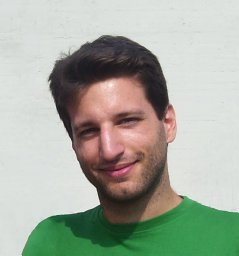

# George Papamakarios

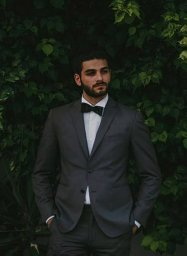

# Theo Pavlakou

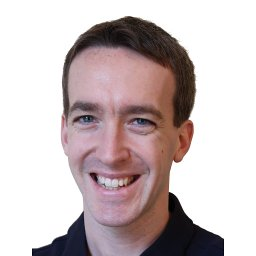
# Iain Murray

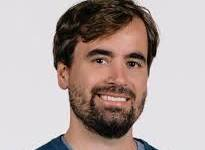
# Diederik P. Kingma

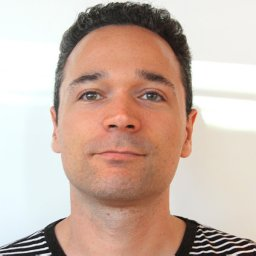
# Tim Salimans

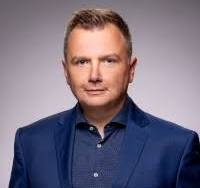
# Rafał Józefowicz

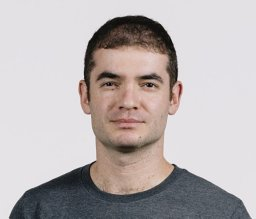
# Ilya Sutskever

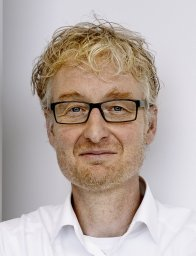
# Max Welling

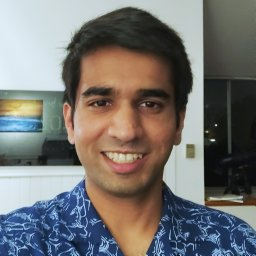
# Prafulla Dhariwal

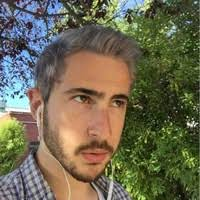
# Will Grathwohl

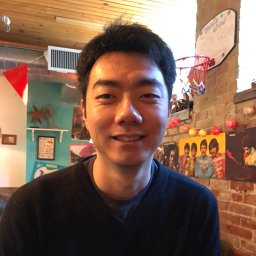
# Ricky Tian Qi Chen

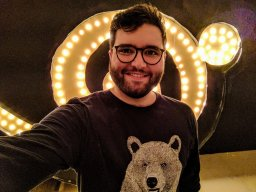
# Jesse Bettencourt

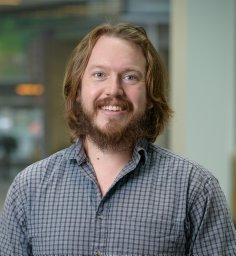
# David Duvenaud

# NICE
# https://arxiv.org/pdf/1410.8516

# RealNVP
# https://arxiv.org/pdf/1605.08803

# MAF
# https://arxiv.org/pdf/1705.07057

# IAF
# https://arxiv.org/pdf/1606.04934

# Glow
# https://arxiv.org/pdf/1807.03039

# FFJORD
# https://arxiv.org/pdf/1810.01367

## 0) The shared core idea: change of variables + tractable Jacobian

All flow-based models learn an **invertible mapping** between data
$$
x \in \mathbb{R}^D
$$
and a simple base distribution
$$
z \sim p_Z \quad (\text{typically } \mathcal{N}(0, I)).
$$

If
$$
x = f(z),
$$
then by the change-of-variables formula,
$$
\log p_X(x)
=
\log p_Z(z)
-
\log \left| \det \frac{\partial f(z)}{\partial z} \right|.
$$

The entire design problem is therefore:

1. Make \( f \) **expressive**.
2. Keep the **inverse cheap**.
3. Keep the **log-determinant of the Jacobian cheap**.

Naively computing a determinant is \( O(D^3) \), which is infeasible in high dimensions.  
Historically, flows enforced architectural structure to avoid this cost.

FFJORD makes this explicit and frames earlier flows as architectural workarounds for determinant computation.

---

## 1) NICE (Dinh et al., 2014/2015): coupling layers → easy inverse, easy log-det

### Main idea

NICE introduces **coupling layers**. The input is split into two parts:
\[
x = (x_1, x_2).
\]

One part is left unchanged; the other is transformed as a function of the unchanged part.  
For **additive coupling**:
\[
\begin{aligned}
y_1 &= x_1, \\
y_2 &= x_2 + m(x_1).
\end{aligned}
\]

The Jacobian is triangular with ones on the diagonal, hence:
\[
\left| \det J \right| = 1,
\]
and inversion is trivial.

### What it solved

- A practical way to construct deep invertible models by stacking layers.
- Exact likelihood computation with cheap inverse and Jacobian.

### Limitation

Additive coupling is **volume preserving**:
\[
\left| \det J \right| = 1
\quad \text{for every layer}.
\]

The model cannot perform local expansion or contraction of volume.

### NICE’s fix (partial)

A final **diagonal scaling layer** \( S \) is added:
\[
\log p_X(x) \;\text{gains}\; \sum_i \log |S_{ii}|.
\]

This allows global volume change, but it is **not input-dependent** and therefore limited in expressivity.

---

## 2) Real NVP (Dinh et al., 2016/2017): affine coupling → non-volume-preserving flows

### Main idea

Replace additive coupling with **affine coupling**:
\[
\begin{aligned}
y_1 &= x_1, \\
y_2 &= x_2 \odot \exp(s(x_1)) + t(x_1).
\end{aligned}
\]

The log-determinant becomes:
\[
\log \left| \det J \right| = \sum_i s_i(x_1),
\]
which is cheap and **input-dependent**.

### What it solved vs. NICE

- Removes the volume-preserving restriction in a principled way.
- Allows each coupling layer to locally expand or contract space.

### Additional practical contributions

- **Multi-scale architecture** with factor-out operations for images.
- CNN and residual networks inside coupling transforms.
- **Batch Normalization** inside flows, with its contribution explicitly added to the Jacobian determinant.

### New limitations introduced

- BatchNorm depends on minibatch statistics and becomes unstable when batch size is very small.
- Mixing across dimensions is often done via fixed permutations (e.g., channel reversal), which limits expressivity.

---

## 3) Glow (Kingma & Dhariwal, 2018): stable large-scale training + learned mixing

Glow explicitly builds on NICE and Real NVP, targeting **stability and expressivity** for high-resolution images.

### 3.1 Actnorm: fixing BatchNorm

BatchNorm injects noise inversely proportional to batch size, which is problematic when training with batch size 1.

Glow introduces **Actnorm**:
- Per-channel affine parameters.
- Initialized using the first minibatch to achieve zero mean and unit variance.
- Then treated as standard trainable parameters.

This removes batch-statistic noise while preserving invertibility.

### 3.2 Invertible \(1 \times 1\) convolution: learn the mixing

Real NVP uses fixed permutations. Glow replaces these with a **learned invertible \(1 \times 1\) convolution**.

For spatial size \( h \times w \) and channel matrix \( W \):
\[
\log |\det J|
=
h \cdot w \cdot \log |\det W|.
\]

To reduce computational cost, \( W \) is parameterized via LU decomposition:
\[
\log |\det W| = \sum_i \log |s_i|.
\]

### What Glow solves

- Removes batch-size dependence via Actnorm.
- Learns optimal channel mixing instead of relying on hand-crafted permutations.
- Maintains exact invertibility and tractable likelihoods.

---

## 4) IAF (Kingma et al., 2016): autoregressive flows for variational inference

### Main idea

IAF constructs a sequence of invertible transformations:
\[
z_t = f_t(z_{t-1}, x),
\]
starting from a simple base distribution.

The core update is:
\[
z_t = \mu_t + \sigma_t \odot z_{t-1},
\]
where \( \mu_t \) and \( \sigma_t \) are produced by autoregressive networks.

The Jacobian is triangular, so:
\[
\left| \det J \right| = \prod_i \sigma_{t,i}.
\]

A numerically stable gated version is:
\[
\begin{aligned}
\sigma_t &= \text{sigmoid}(s_t), \\
z_t &= \sigma_t \odot z_{t-1} + (1 - \sigma_t) \odot m_t.
\end{aligned}
\]

### What it solved

- Addresses the inefficiency of planar/radial flows in high dimensions.
- Scales variational posteriors to large latent spaces with tractable likelihoods.

### Key tradeoff

- Sampling from the approximate posterior is efficient and parallel.
- Depending on direction, density evaluation or inversion can be sequential.

This tradeoff becomes explicit in MAF.

---

## 5) MAF (Papamakarios et al., 2017): autoregressive flows for density estimation

### Main idea

MAF uses masked autoregressive networks (e.g., MADE) to enforce autoregressive structure while allowing parallel parameter computation on GPUs.

It remains in the same change-of-variables framework:
- Invertible transforms.
- Triangular Jacobians.
- Cheap log-determinants.

### What it clarified

- MAF shows that maximum-likelihood training of MAF corresponds to variational training of an implicit IAF.
- This exposes a deep **duality** between IAF and MAF.

### Critical distinction

- **IAF**: fast sampling, slow density evaluation → ideal for variational inference.
- **MAF**: fast density evaluation, slow sampling → ideal for density estimation.

MAF does not replace IAF; it optimizes a different objective.

---

## 6) FFJORD (Grathwohl et al., 2018): continuous-time flows without architectural constraints

### Main idea

FFJORD targets the core historical restriction:  
flows relied on specially structured Jacobians to avoid determinant computation.

It adopts **continuous-time normalizing flows**:
\[
\frac{d z(t)}{d t} = f(z(t), t),
\]
where the log-density evolves as:
\[
\frac{d}{d t} \log p(z(t))
=
- \operatorname{Tr} \left( \frac{\partial f}{\partial z} \right).
\]

### Key contribution

FFJORD introduces an **unbiased stochastic estimator** of the trace with
\[
O(D)
\]
cost, removing the need for triangular or block-structured Jacobians.

### What FFJORD solves

- Eliminates the need for coupling layers, permutations, or autoregressive ordering.
- Enables unrestricted neural architectures inside flows.
- Shifts the burden from architectural design to stochastic estimation.

---

## One clean progress-chain summary

### Coupling-based line (parallel sampling, easy inverse)

- **NICE**: additive coupling ⇒ \(|\det J| = 1\); needs global scaling.
- **Real NVP**: affine coupling ⇒ input-dependent volume change; BN introduces small-batch issues.
- **Glow**: Actnorm fixes BN; invertible \(1 \times 1\) convolution learns mixing.

### Autoregressive line (triangular Jacobians)

- **IAF**: scalable VI posteriors with fast sampling.
- **MAF**: scalable density estimation; exposes IAF–MAF duality.

### Continuous-time line (remove constraints)

- **FFJORD**: replaces determinant tricks with unbiased \(O(D)\) trace estimation, enabling fully unrestricted architectures.


### 1) NICE (Dinh, Krueger, Bengio, 2014/2015)

**Authors:** :contentReference[oaicite:0]{index=0}, :contentReference[oaicite:1]{index=1}, :contentReference[oaicite:2]{index=2}

| Key problems / gaps | How this limits prior work | How NICE proposes to solve it |
|---|---|---|
| Need exact likelihood training with an invertible generative mapping via change of variables. | Many deep generative models (e.g., Boltzmann machines, early VAEs, GAN-like approaches) do not provide tractable exact likelihoods or rely on approximate inference; autoregressive sampling is often sequential and difficult to parallelize. | Use a **bijective deterministic transform** \( f \) and optimize the **exact log-likelihood** using the change-of-variables formula. |
| Need an invertible building block with a tractable Jacobian determinant. | General bijections have Jacobian determinants that are expensive to compute (\(O(D^3)\)), forcing severe architectural restrictions or approximations. | Introduce **additive coupling layers**, whose Jacobian is triangular with unit diagonal, giving \(|\det J| = 1\) and a trivial inverse. |
| Efficient sampling and inference for high-dimensional data. | Element-wise autoregressive schemes make sampling slow and non-parallelizable in high dimensions (e.g., images). | Use **blockwise coupling** so inversion and sampling are efficient and parallelizable via the inverse transformation. |


### 2) Improved Variational Inference with Inverse Autoregressive Flow (Kingma et al., 2016)

**Authors:** :contentReference[oaicite:0]{index=0}, :contentReference[oaicite:1]{index=1}, ozefowicz","machine learning researcher"], :contentReference[oaicite:3]{index=3}, :contentReference[oaicite:4]{index=4}

| Key problems / gaps | How this limits prior work | How IAF proposes to solve it |
|---|---|---|
| Variational posteriors (e.g., factorized Gaussians) are too weak to approximate complex true posteriors. | Limited expressiveness of the variational family leads to poor ELBO optimization and suboptimal likelihoods, especially in high-dimensional latent spaces. | Introduce **Inverse Autoregressive Flow (IAF)** to enrich the approximate posterior with a sequence of expressive, invertible transformations, significantly improving over factorized Gaussian posteriors. |
| Existing normalizing flows (e.g., planar and radial flows) do not clearly scale to high-dimensional latent variables. | Their limited capacity and inefficient scaling restrict applicability to large image models and high-dimensional latent spaces. | Use **autoregressive neural networks** to parameterize flows, yielding transformations that scale effectively with latent dimensionality. |
| Coupling-style or weak flows may require long chains to achieve sufficient expressivity. | Increasing the number of flow steps raises computational cost and can reduce practical efficiency. | Employ **autoregressive structure** to achieve stronger transformations per step; additionally use ordering strategies (e.g., variable order reversal between steps) to improve mixing without excessively long chains. |

**How it “solves” NICE’s limitations**

NICE establishes the core idea of **tractable likelihoods via invertible transformations**, but it is primarily designed as a **standalone generative model** with coupling layers whose expressiveness (especially additive coupling) is limited and whose motivation is density estimation and sampling.

**Inverse Autoregressive Flow (IAF)** takes the same change-of-variables foundation and **repositions it inside variational inference**. Instead of modeling \( p(x) \) directly as in NICE, IAF focuses on enriching the **variational posterior** \( q(z \mid x) \). The key shift is conceptual and practical:

- NICE answers: *How can we build an invertible generator with exact likelihood?*
- IAF answers: *How can we make variational posteriors expressive enough in high-dimensional latent spaces while keeping the ELBO tractable?*

By using **autoregressive transformations**, IAF achieves much stronger per-step expressiveness than NICE-style coupling layers, allowing effective scaling to high-dimensional latent variables without relying on long chains of weak transforms. In this sense, IAF does not refine NICE as a generative density model; instead, it **extends the flow paradigm into variational inference**, solving a different but closely related bottleneck: posterior expressiveness rather than data-space modeling.


### 3) Density Estimation Using Real NVP (Dinh et al., 2016/2017)

**Authors:** :contentReference[oaicite:0]{index=0}, :contentReference[oaicite:1]{index=1}, :contentReference[oaicite:2]{index=2}

| Key problems / gaps | How this limits prior work | How Real NVP proposes to solve it |
|---|---|---|
| Naively applying change of variables yields models that are computationally expensive and poorly conditioned. | Prevents scaling exact-likelihood invertible models to high-dimensional continuous data such as images. | Design **flexible yet structured architectures** that keep both inference and log-likelihood computation tractable at scale. |
| Desire for bijective training without GAN discriminators or VAE-style approximate inference. | GANs lack tractable likelihoods and suffer from training instability and evaluation difficulties; VAEs rely on approximate posteriors. | If the transformation \( g \) is **bijective**, train directly by **maximum likelihood** using the change-of-variables formula. |
| Need deeper and more expressive transformations for image modeling. | Earlier flows such as NICE rely on **additive coupling**, which is highly tractable but limits per-layer expressiveness. | Introduce **affine coupling layers** with input-dependent scaling, and employ **batch normalization** and **deep multi-scale architectures** to significantly increase modeling power. |

**How it “solves” NICE’s limitations**

NICE demonstrates that coupling layers make exact likelihood and invertibility practical, but its **additive coupling** restricts expressiveness and volume change. Real NVP directly addresses this by moving to **affine coupling**, enabling input-dependent expansion and contraction of space. Combined with deep, multi-scale image architectures and normalization, Real NVP explicitly targets **high-dimensional continuous data** while preserving the same core advantages of NICE: exact likelihoods, efficient inversion, and scalable training.


### 4) Masked Autoregressive Flow for Density Estimation (Papamakarios et al., 2017)

**Authors:** :contentReference[oaicite:0]{index=0}, :contentReference[oaicite:1]{index=1}, :contentReference[oaicite:2]{index=2}

| Key problems / gaps | How this limits prior work | How MAF proposes to solve it |
|---|---|---|
| Need strong density estimation with exact, tractable log-likelihoods. | Many generative models emphasize sampling quality or visual realism; they do not directly optimize or even provide exact likelihoods, limiting their use for density estimation tasks. | Use **masked autoregressive transformations** to build highly flexible densities while maintaining **exact log-density evaluation**, enabling direct maximum-likelihood training. |
| Unclear relationship and trade-offs between autoregressive flows used in variational inference (IAF) and flows for density estimation. | Methods designed for variational inference are optimized for fast sampling from posteriors, not for fast likelihood evaluation; this mismatch obscures when each method should be used. | Explicitly analyze and formalize the **MAF–IAF duality**, showing that training MAF by maximum likelihood corresponds to variationally training an implicit IAF under a specific objective mapping. |
| Optimization difficulties in deep autoregressive stacks. | Deep compositions of autoregressive layers can suffer from poor conditioning and unstable training. | Insert **batch normalization** between autoregressive layers to stabilize optimization and improve convergence in deep MAF models. |

**How it “solves” prior limitations**

Relative to coupling-based flows such as Real NVP and VI-oriented autoregressive flows such as IAF, **MAF explicitly prioritizes density estimation performance**. It preserves exact likelihoods while providing highly expressive autoregressive transformations, and it clarifies that the apparent differences between MAF and IAF are not fundamental but arise from **which direction of the transformation is made autoregressive**. In doing so, MAF both improves practical density estimation and conceptually unifies autoregressive flows under a common change-of-variables framework.


### 5) Glow: Generative Flow with Invertible 1×1 Convolutions (Kingma & Dhariwal, 2018)

**Authors:** :contentReference[oaicite:0]{index=0}, :contentReference[oaicite:1]{index=1}

| Key problems / gaps | How this limits prior work | How Glow proposes to solve it |
|---|---|---|
| Flow models are theoretically appealing but under-adopted in practice. | Compete with GANs, VAEs, and autoregressive models; without strong empirical performance and scalability, flows see limited adoption. | Reposition flows as uniquely offering **exact inference**, **exact log-likelihood**, and **efficient, parallelizable synthesis**, making their advantages explicit and practical. |
| Autoregressive likelihood models require sequential generation. | Sampling cost grows linearly with data dimensionality, making large images or videos slow to generate. | Use **flow-based architectures** where synthesis is performed by a single inverse pass, enabling **fully parallel generation**. |
| Existing flow building blocks (NICE, Real NVP) have limited mixing and stability issues. | Fixed permutations restrict channel interaction; BatchNorm in Real NVP introduces instability with small batch sizes. | Introduce **new flow components**: **Actnorm** (batch-size–independent normalization) and **invertible \(1 \times 1\) convolutions** to learn channel mixing while keeping tractable Jacobians. |

**How it “solves” Real NVP’s limitations**

Real NVP establishes affine coupling and multi-scale architectures but relies on **Batch Normalization** and **fixed permutations**, which hinder stability and expressivity at scale. Glow preserves the core advantages of reversible flows—exact likelihoods and efficient inversion—while replacing fragile or hand-designed components with **learned, deterministic, and scalable building blocks**. By emphasizing **parallelizable synthesis** and robust training for high-resolution data, Glow transforms flows from a conceptual alternative into a **competitive, practical generative modeling framework**.


### 6) FFJORD: Free-form Continuous Dynamics for Scalable Reversible Generative Models (Grathwohl et al., 2018)

**Authors:** :contentReference[oaicite:0]{index=0}, :contentReference[oaicite:1]{index=1}, :contentReference[oaicite:2]{index=2}, :contentReference[oaicite:3]{index=3}

| Key problems / gaps | How this limits prior work | How FFJORD proposes to solve it |
|---|---|---|
| Standard reversible flows require architectural restrictions to keep log-determinant computation tractable (often \(O(D^3)\)). | Leads to coupling layers, triangular Jacobians, or fixed permutations, imposing **awkward structural constraints** that limit expressiveness. | Move to **continuous normalizing flows (CNFs)** where transformations are defined by ODEs and log-density evolution depends on a **trace**, not a determinant (instantaneous change-of-variables formula). |
| Even CNFs retain computational constraints due to trace computation. | Naively computing the trace costs \(O(D^2)\), still restricting usable architectures. | Introduce **Hutchinson’s unbiased stochastic trace estimator**, reducing likelihood computation to **\(O(D)\)** and allowing **unrestricted neural architectures**. |
| Need scalable training and evaluation on modern hardware. | ODE-based models can be slow or unstable without careful numerical implementation. | Implement **GPU-based adaptive ODE solvers** and an efficient training pipeline, making continuous flows practical at scale. |

**How it “solves” Glow / Real NVP’s core limitation**

Glow and Real NVP achieve exact likelihoods and efficient one-pass sampling, but only by **carefully engineering Jacobian-friendly architectures** (coupling layers, permutations, invertible convolutions). FFJORD removes this requirement entirely. By modeling transformations as **continuous-time dynamics** and using **unbiased trace estimation**, FFJORD enables **free-form Jacobians** with exact likelihood computation. This shifts the design burden from architectural constraints to stochastic estimation and numerical integration, fundamentally expanding the expressiveness of flow-based generative models while preserving tractability.
